# Name: Paavani Ramakrishna
# Git Username: paavani2000
# USC id: 7696462483

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import ClassifierChain

# 1. Decision Trees as Interpretable Models

(a) Download the Acute Inflammations data from the UCI Machine Learning Repository.

In [3]:
column_headers = ['Temperature','Nausea','Lumbar','Urine','Micturition','Urethra','Inflammation', 'Nephritis']
df = pd.read_csv("../Data/diagnosis.data", sep='\t', encoding='utf_16', names=column_headers, decimal=',')
df.head()

,Temperature,Nausea,Lumbar,Urine,Micturition,Urethra,Inflammation,Nephritis
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


In [4]:
le = LabelEncoder()
for col in df.columns:
    if col=='Temperature':
        continue
    df[col] = le.fit_transform(df[col])
df

,Temperature,Nausea,Lumbar,Urine,Micturition,Urethra,Inflammation,Nephritis
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1


In [5]:
X = df.iloc[:, :-2]
y = df.drop(columns = ['Temperature','Nausea','Lumbar','Urine','Micturition','Urethra'])
print(X)

     Temperature  Nausea  Lumbar  Urine  Micturition  Urethra
0           35.5       0       1      0            0        0
1           35.9       0       0      1            1        1
2           35.9       0       1      0            0        0
3           36.0       0       0      1            1        1
4           36.0       0       1      0            0        0
..           ...     ...     ...    ...          ...      ...
115         41.4       0       1      1            0        1
116         41.5       0       0      0            0        0
117         41.5       1       1      0            1        0
118         41.5       0       1      1            0        1
119         41.5       0       1      1            0        1

[120 rows x 6 columns]


In [6]:
print(y)

     Inflammation  Nephritis
0               0          0
1               1          0
2               0          0
3               1          0
4               0          0
..            ...        ...
115             0          1
116             0          0
117             0          1
118             0          1
119             0          1

[120 rows x 2 columns]


(b) Build a decision tree on the whole data set and plot it.

In [7]:
tree_clf = DecisionTreeClassifier(random_state=0)
tree_clf.fit(X, y)
classifier_chain = ClassifierChain(tree_clf)
classifier_chain.fit(X, y)

y_pred = classifier_chain.predict(X)
final_classifier = tree_clf.fit(X, y_pred)

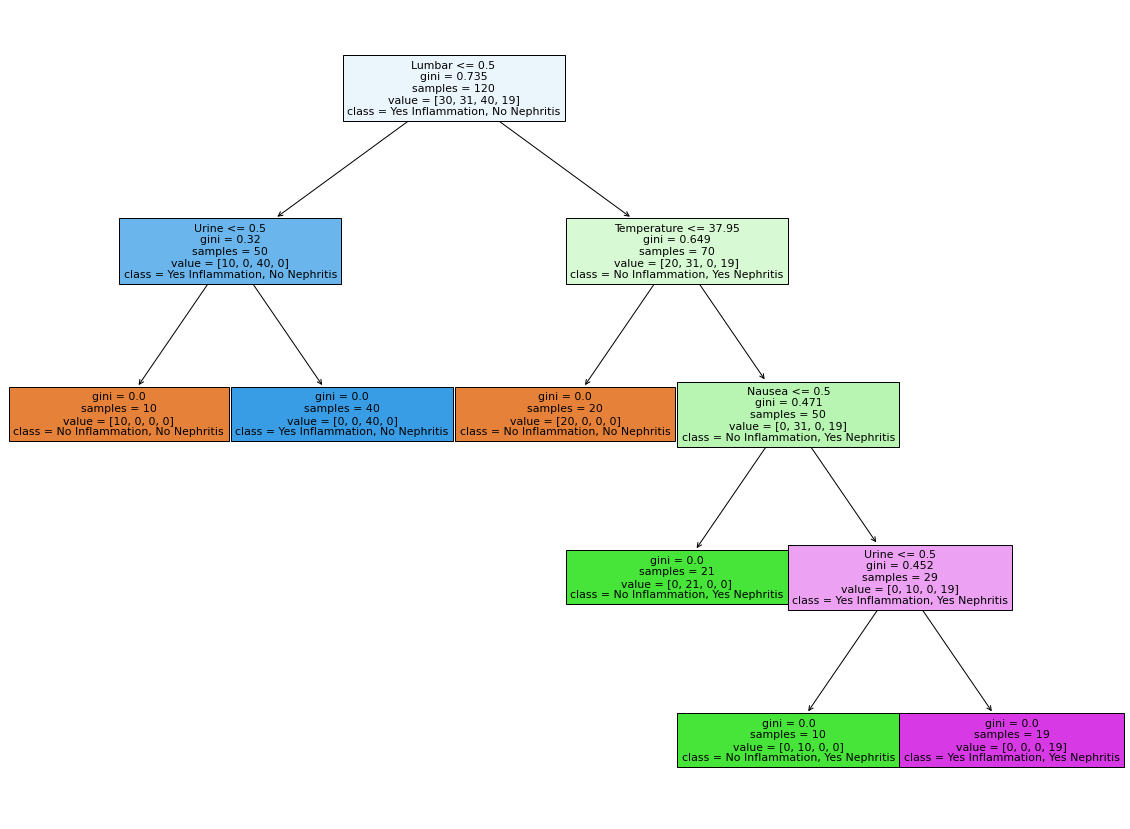

In [8]:
# Define class labels for better interpretation
# No Inflammation, No Nephritis - 0
# Yes Inflammation, No Nephritis - 1
# No Inflammation, Yes Nephritis - 2
# Yes Inflammation, Yes Nephritis - 3

class_labels = ["No Inflammation, No Nephritis", "Yes Inflammation, No Nephritis", 
                "No Inflammation, Yes Nephritis", "Yes Inflammation, Yes Nephritis"]

predicted_labels = []
for pred in y_pred:
    if pred[0] == 0 and pred[1] == 0:
        predicted_labels.append("No Inflammation, No Nephritis")
    elif pred[0] == 1 and pred[1] == 0:
        predicted_labels.append("Yes Inflammation, No Nephritis")
    elif pred[0] == 0 and pred[1] == 1:
        predicted_labels.append("No Inflammation, Yes Nephritis")
    else:
        predicted_labels.append("Yes Inflammation, Yes Nephritis")

# Train decision tree again using predicted categorical labels
final_classifier = DecisionTreeClassifier(random_state=42)
final_classifier.fit(X, predicted_labels)

# Plot the decision tree with meaningful class labels
fig, ax = plt.subplots(figsize=(20, 15))
plot_tree(final_classifier, feature_names=X.columns, class_names=np.unique(predicted_labels), filled=True)
plt.show()

(c)Convert the decision rules into a set of IF-THEN rules.

In [9]:
from sklearn.tree import export_text

def extract_rules(decision_tree, feature_names):
    tree_rules = export_text(decision_tree, feature_names=feature_names).split("\n")
    formatted_rules = []
    for rule in tree_rules:
        if "|" in rule:
            depth = rule.count("|")
            formatted_rule = "    " * depth + "IF " + rule.split("--- ")[-1].replace(":", " THEN")
            formatted_rules.append(formatted_rule)
        else:
            formatted_rules.append(rule)
    return "\n".join(formatted_rules)

rules = extract_rules(final_classifier, list(X.columns))
print("Decision Tree IF-THEN Rules:\n")
print(rules)

Decision Tree IF-THEN Rules:

    IF Lumbar <= 0.50
        IF Urine <= 0.50
            IF class THEN No Inflammation, No Nephritis
        IF Urine >  0.50
            IF class THEN Yes Inflammation, No Nephritis
    IF Lumbar >  0.50
        IF Temperature <= 37.95
            IF class THEN No Inflammation, No Nephritis
        IF Temperature >  37.95
            IF Nausea <= 0.50
                IF class THEN No Inflammation, Yes Nephritis
            IF Nausea >  0.50
                IF Urine <= 0.50
                    IF class THEN No Inflammation, Yes Nephritis
                IF Urine >  0.50
                    IF class THEN Yes Inflammation, Yes Nephritis



d. Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

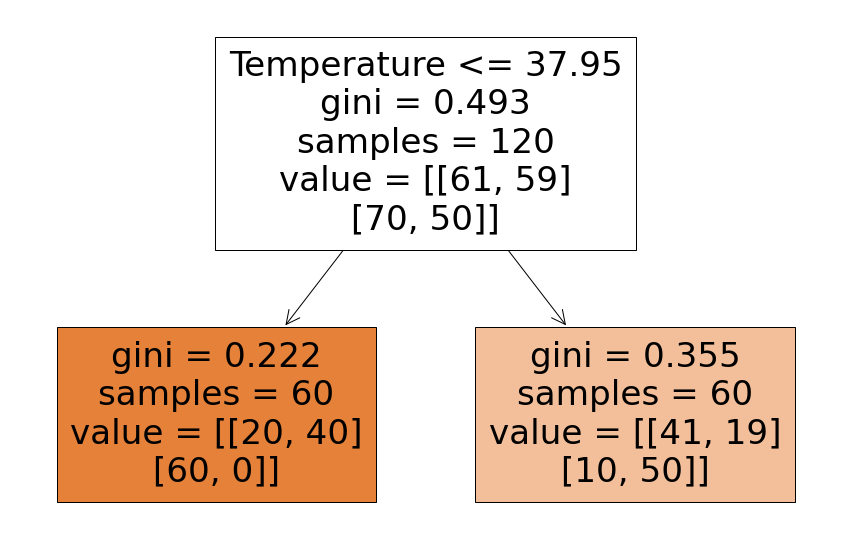

In [10]:
path = tree_clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas  # Retrieve the values of alpha

# Create trees for each alpha and store them
trees = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    trees.append(clf)

# Select the second-to-last tree (just before the smallest tree)
optimal_tree = trees[-2]  # second-to-last tree

# Plot the pruned tree
plt.figure(figsize=(15, 10))
plot_tree(optimal_tree, feature_names=X.columns, class_names=class_labels, filled=True)
plt.show()


Text(0.5, 1.0, 'Total Impurity vs Effective Alpha for Training Set')

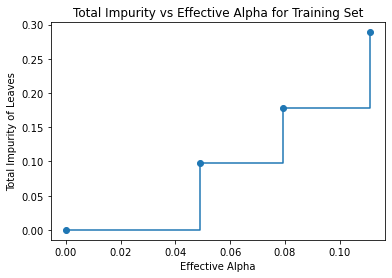

In [11]:
# Assuming the pruning path has already been computed
ccp_alphas = path.ccp_alphas  # Retrieve the values of alpha
impurities = path.impurities  # Retrieve the total impurities for each alpha

# Plot the relationship between alpha and impurity
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("Effective Alpha")
ax.set_ylabel("Total Impurity of Leaves")
ax.set_title("Total Impurity vs Effective Alpha for Training Set")

# 2. The LASSO and Boosting for Regression

(a) Download the Communities and Crime data from the UCI Machine Learning Repository. Use the first 1495 rows of data as the training set and the rest as the test set

In [12]:
df2 = pd.read_csv("../Data/communities.data", header=None, na_values='?', encoding='ISO-8859-1')

# Use the first 1495 rows as the training set and the rest as the test set
train_data = df2.iloc[:1495]
test_data = df2.iloc[1495:]

In [13]:
df2

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


(b) The data set has missing values. Use a data imputation technique to handle the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [14]:
from sklearn.impute import SimpleImputer
train_data = train_data.drop(columns=[0, 1, 2, 3, 4])
test_data = test_data.drop(columns=[0, 1, 2, 3, 4])
df2 = df2.drop(columns=[0, 1, 2, 3, 4])


In [15]:
df2.head()

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [16]:
print("Missing values per feature:")
print(df2.isnull().sum())

# For numerical columns, we'll use the mean strategy, and for categorical columns, we'll use the most frequent strategy
imputer = SimpleImputer(strategy='mean')  # For numerical data, you can change to 'median' or 'most_frequent' for categorical
df2_imputed = pd.DataFrame(imputer.fit_transform(df2), columns=df2.columns)

Missing values per feature:
5         0
6         0
7         0
8         0
9         0
       ... 
123    1675
124    1675
125       0
126    1675
127       0
Length: 123, dtype: int64


In [17]:
df2_imputed.head()

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03


In [18]:
train_data_imputed = df2_imputed.iloc[:1495]
test_data_imputed = df2_imputed.iloc[1495:]

(c) Plot a correlation matrix for the features in the data set.

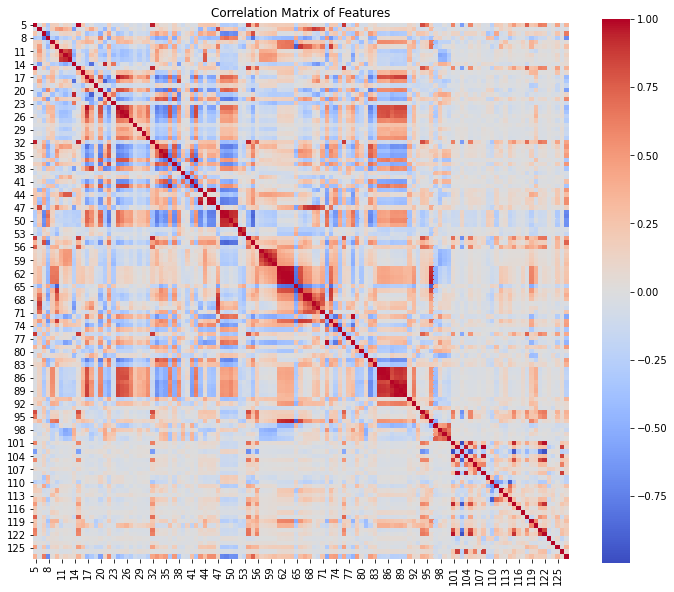

In [19]:
import seaborn as sns
# Assuming 'train_data_imputed' is your DataFrame containing the imputed data
train_df = pd.DataFrame(train_data_imputed)

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(train_df.corr(), cmap="coolwarm", square=True)

# Add title to the heatmap
plt.title("Correlation Matrix of Features")

# Display the plot
plt.show()


(d) Calculate the Coefficient of Variation (CV) for each feature, where CV = s / m, where s is the sample standard deviation and m is the sample mean.

In [20]:
mean_values = df2.mean()
std_values = df2.std()

# Calculate the Coefficient of Variation (CV)
cv_values = std_values / mean_values

# Display the CV values for each feature
print("Coefficient of Variation (CV) for each feature:")
print(cv_values)

Coefficient of Variation (CV) for each feature:
5      2.203503
6      0.353298
7      1.410920
8      0.323782
9      1.359162
         ...   
123    0.306251
124    0.921372
125    2.555266
126    0.844368
127    0.979015
Length: 123, dtype: float64


(e) Pick the top √128 (rounded down) features with the highest CV. Create scatter plots and box plots for these features. Can you draw conclusions about the significance of these features just by looking at the scatter plots?

In [21]:
cv_values.sort_values(ascending=False)

95     4.407702
94     3.485481
54     2.994196
56     2.900497
125    2.555266
         ...   
100    0.304240
12     0.290693
65     0.288673
77     0.269647
103    0.143013
Length: 123, dtype: float64

In [22]:
top_features = cv_values.sort_values(ascending=False)[:11]
top_features

95     4.407702
94     3.485481
54     2.994196
56     2.900497
125    2.555266
32     2.304970
5      2.203503
15     2.001744
101    1.984599
113    1.979371
76     1.958780
dtype: float64

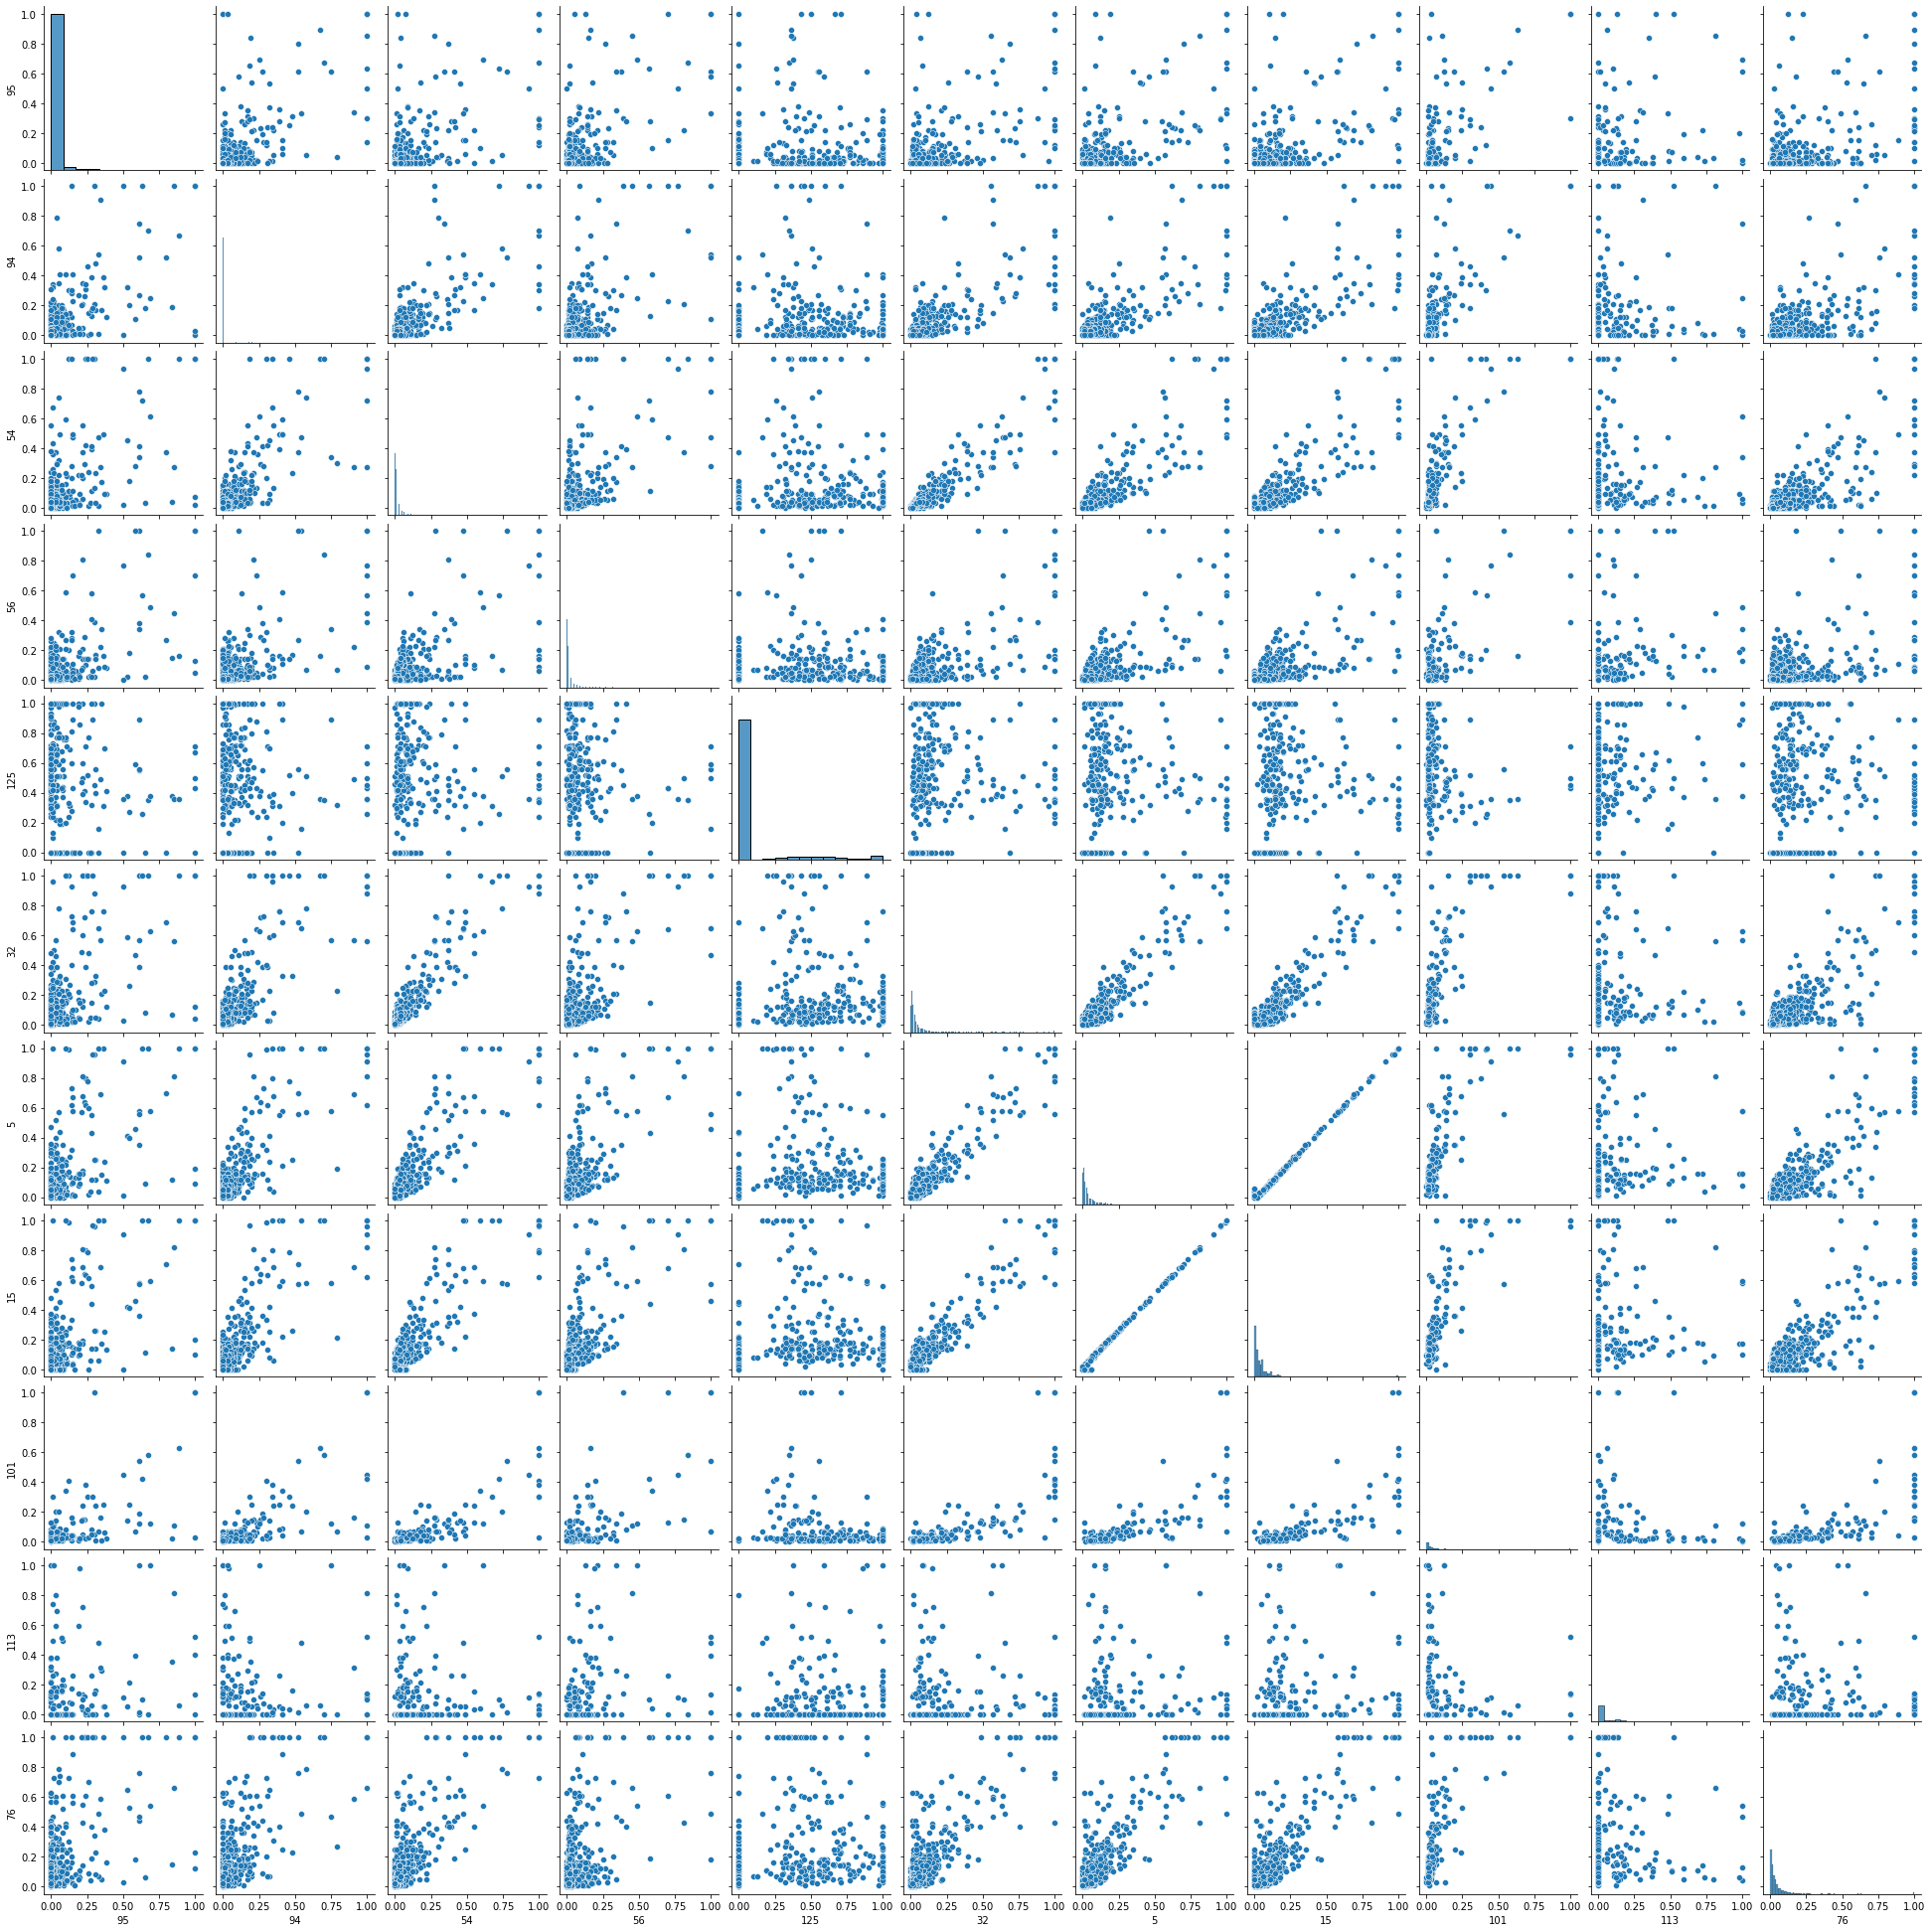

In [23]:
top_features_data = train_data[top_features.index]

p=sns.pairplot(top_features_data)

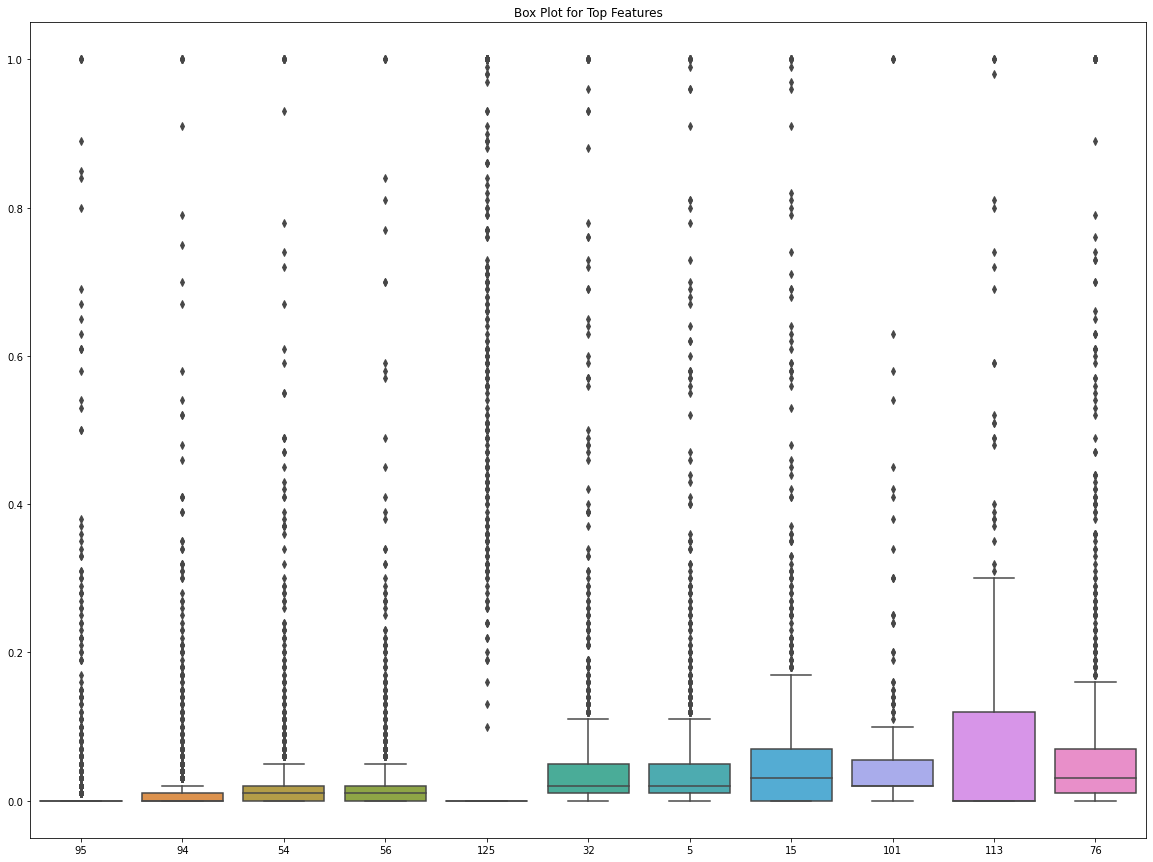

In [24]:
plt.figure(figsize=(20, 15))
sns.boxplot(data=top_features_data)
plt.title("Box Plot for Top Features")
plt.xticks()  # Rotate feature names if necessary
plt.show()

Conclusion: By looking at the scatter plots and box plots, we can conclude that:

- High CV: Features with high CV tend to have more variability, which may indicate they have significant predictive value.
- Box Plot Insights: Features with a narrow spread and few outliers might be less significant, while features with a wide range and more outliers could have higher predictive value.

(f) Fit a linear model using least squares on the training set and report the test error.

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train = train_data_imputed.iloc[:, :-1]
y_train = train_data_imputed.iloc[:, -1]
X_test = test_data_imputed.iloc[:, :-1]
y_test = test_data_imputed.iloc[:, -1]

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error (MSE): {mse}")


Test Mean Squared Error (MSE): 0.7897255274396388


(g) Fit a ridge regression model on the training set, selecting the regularization parameter λ using cross-validation. Report the test error obtained.

In [27]:
from sklearn.linear_model import RidgeCV
alpha_values = [0.01, 0.1, 1, 10, 100]
ridge_cv = RidgeCV(alphas=alpha_values, store_cv_values=True)
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.alpha_
print(f"Best Regularization Parameter (λ): {best_alpha}")

Best Regularization Parameter (λ): 1.0


In [28]:
y_pred_ridge = ridge_cv.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"Test Mean Squared Error (MSE) with Ridge Regression: {mse_ridge}")

Test Mean Squared Error (MSE) with Ridge Regression: 0.01773708110429919


(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model.
- Repeat with standardized features. Report the test error for both cases and compare them.

In [29]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

alpha_values = [0.01, 0.1, 1, 10, 100]
lasso_cv = LassoCV(alphas=alpha_values, cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_cv.alpha_
print(f"Best Regularization Parameter (λ) for LASSO: {best_alpha_lasso}")
y_pred_lasso = lasso_cv.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Test Mean Squared Error (MSE) with LASSO (Without Standardization): {mse_lasso}")
selected_features = X_train.columns[lasso_cv.coef_ != 0]
print(f"Selected Features by LASSO: {list(selected_features)}")

Best Regularization Parameter (λ) for LASSO: 0.01
Test Mean Squared Error (MSE) with LASSO (Without Standardization): 0.020919681104181242
Selected Features by LASSO: [8, 49, 55]


In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_cv_scaled = LassoCV(alphas=alpha_values, cv=5, random_state=42)
lasso_cv_scaled.fit(X_train_scaled, y_train)

best_alpha_lasso_scaled = lasso_cv_scaled.alpha_
print(f"Best λ for LASSO (Standardized Features): {best_alpha_lasso_scaled}")

y_pred_lasso_scaled = lasso_cv_scaled.predict(X_test_scaled)
mse_lasso_scaled = mean_squared_error(y_test, y_pred_lasso_scaled)
print(f"Test Mean Squared Error (MSE) with LASSO (Standardized Features): {mse_lasso_scaled}")
selected_features_scaled = X_train.columns[lasso_cv_scaled.coef_ != 0]
print(f"Selected Features by LASSO (After Standardization): {list(selected_features_scaled)}")

Best λ for LASSO (Standardized Features): 0.01
Test Mean Squared Error (MSE) with LASSO (Standardized Features): 0.01734465469734718
Selected Features by LASSO (After Standardization): [7, 8, 16, 43, 49, 53, 55, 73, 76, 77, 79, 91, 95, 96]


i. Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lin_reg_pca = LinearRegression()
lin_reg_pca.fit(X_train_pca, y_train)
pca_pred = lin_reg_pca.predict(X_test_pca)

pca_test_error = mean_squared_error(y_test, pca_pred)
print("Test Mean Squared Error (MSE) with PCR:", pca_test_error)

Test Mean Squared Error (MSE) with PCR: 0.02013648831066243


j. In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost 5 to fit the model tree. Determine α (the regularization term) using cross-validation

In [35]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [36]:
import warnings
warnings.filterwarnings(action='ignore')

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

params = {
    'reg_alpha': [1e-3, 1e-2, 0.1, 1, 10],  # L1 Regularization values
    'n_estimators': [100, 200],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1],  # Learning rate
    'max_depth': [3, 5]  # Depth of trees
}

modelXGB = XGBRegressor(objective='reg:squarederror', random_state=42)

gscv = GridSearchCV(estimator=modelXGB, param_grid=params, cv=5, scoring='neg_mean_squared_error', verbose=True, n_jobs=-1)
grid_model = gscv.fit(X_train, y_train)

best_xgb = grid_model.best_estimator_

y_pred = best_xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f"Optimal α (L1 Regularization): {grid_model.best_params_['reg_alpha']}")
print(f"Test Mean Squared Error (MSE) with Optimal L1 Regularization: {mse}")
print(f"Best Parameters: {grid_model.best_params_}")


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Optimal α (L1 Regularization): 0.001
Test Mean Squared Error (MSE) with Optimal L1 Regularization: 0.016254602939634565
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.001}


The model performs well with a low test error, indicating it generalizes effectively to new data. The small L1 penalty suggests that most features are useful, and overfitting is well-controlled with a balanced depth and learning rate. 